<a href="https://colab.research.google.com/github/madhu-111/DETECTION-OF-EYE-DISEASES-/blob/main/Eye_disease_classification2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
pip install opendatasets

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
from torch.utils.data import random_split,DataLoader
import torchvision.transforms as transforms
from torchvision.datasets import ImageFolder
import matplotlib.pyplot as plt
import numpy as np
import opendatasets as od


In [ ]:
torch.cuda.empty_cache()

In [ ]:
transformation=transforms.Compose([
    transforms.Resize((128, 128)),  # Resize image to 224x224
    transforms.ToTensor(),          # Convert image to tensor
    transforms.Normalize(mean=[0.5,0.5,0.5], std=[0.5,0.5,0.5])  # Normalize if needed
])

In [ ]:
dataset_url="https://www.kaggle.com/datasets/linabennaa/eye-disease-image-dataset-mendeley"
od.download(dataset_url)


Please provide your Kaggle credentials to download this dataset. Learn more: http://bit.ly/kaggle-creds
Your Kaggle username: dyeswanthmadhu
Your Kaggle Key: ··········
Dataset URL: https://www.kaggle.com/datasets/linabennaa/eye-disease-image-dataset-mendeley


In [ ]:
dataset=ImageFolder("./eye-disease-image-dataset-mendeley/Augmented Dataset",transform=transformation)


In [ ]:
print(dataset[0][0].shape)

torch.Size([3, 128, 128])


In [ ]:
dataset.classes

['Central Serous Chorioretinopathy_Color Fundus',
 'Diabetic Retinopathy',
 'Disc Edema',
 'Glaucoma',
 'Healthy',
 'Macular Scar',
 'Myopia',
 'Pterygium',
 'Retinal Detachment',
 'Retinitis Pigmentosa']

In [ ]:
#create train test validation set
total_size = len(dataset)  # 16140 images
train_size = int(0.7 * total_size)    # 11298 images (70%)
val_size = int(0.15 * total_size)     # 2421 images (15%)
test_size = total_size - train_size - val_size  # 2421 images (remaining 15%)

# Perform the split
train_ds, val_ds, test_ds = random_split(dataset, [train_size, val_size, test_size], generator=torch.Generator().manual_seed(42))


In [ ]:
len(train_ds)

11369

In [ ]:
#creating batches
batch=64
train_dl=DataLoader(train_ds,batch_size=batch,shuffle=True,num_workers=4,pin_memory=True)
test_dl=DataLoader(test_ds,batch_size=batch,num_workers=4,pin_memory=True)
val_dl=DataLoader(val_ds,batch_size=2*batch,num_workers=4,pin_memory=True)

/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


In [ ]:
from torchvision.utils import make_grid
stats=((0.4914,0.4822,0.4465),(0.2023,0.1994,0.2010))
def denormalize(images,means,stds):
    means=torch.tensor(means).reshape(1,3,1,1)
    stds=torch.tensor(stds).reshape(1,3,1,1)
    return images*stds+means
def show_batch(dl):
    for images,labels in dl:
        fig,ax=plt.subplots(figsize=(12,12))
        ax.set_xticks([])
        ax.set_yticks([])
        denorm_images=denormalize(images,*stats)
        ax.imshow(make_grid(denorm_images[:64],nrow=8).permute(1,2,0).clamp(0,1))
        break


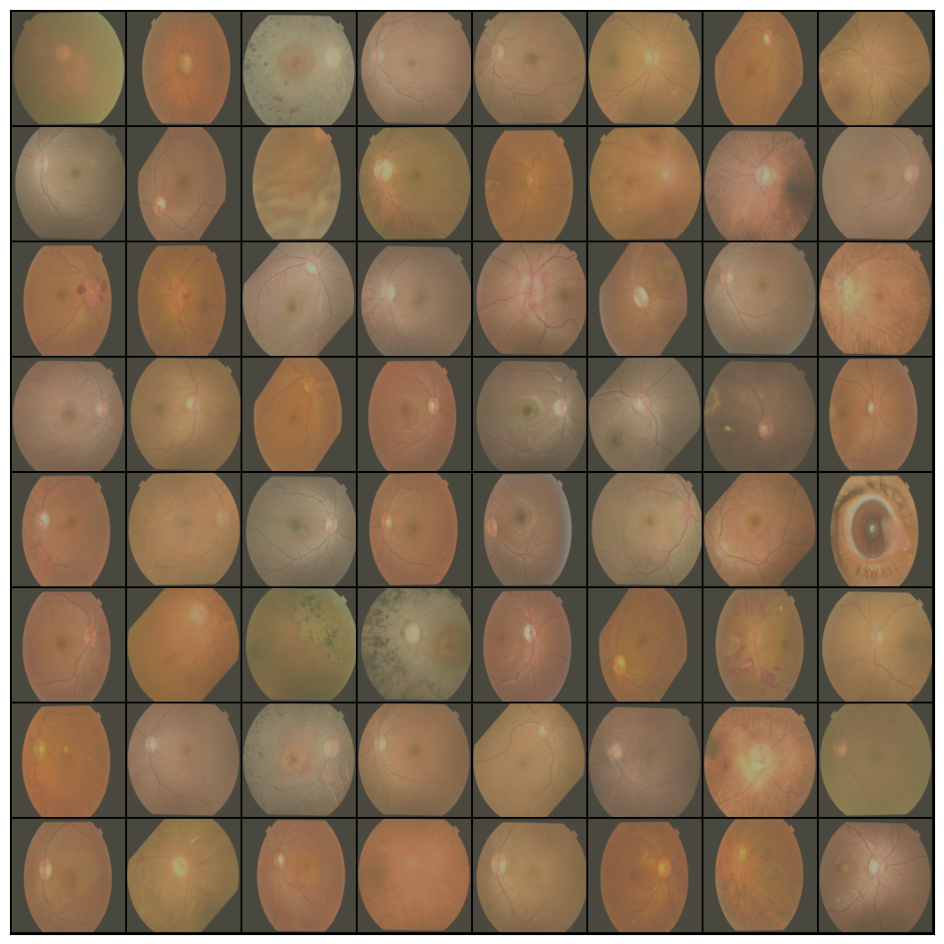

In [ ]:
show_batch(train_dl)

## Defining the Model

In [ ]:
#image classification base
class ImageClassificationBase(nn.Module):
    def training_step(self,batch):
        images,labels=batch
        outputs=self(images)
        loss=F.cross_entropy(outputs,labels)
        return loss
    def validation_step(self,batch):
        images, labels = batch
        out = self(images)                    # Generate predictions
        loss = F.cross_entropy(out, labels)   # Calculate loss
        acc = accuracy(out, labels)           # Calculate accuracy
        return {'val_loss': loss, 'val_acc': acc}
    def validation_epoch_end(self,outputs):
        acc=[x["val_acc"] for x in outputs]
        loss=[x['val_loss'] for x in outputs]

        mean_acc=torch.stack(acc).mean()
        mean_loss=torch.stack(loss).mean()
        return {"val_loss":mean_loss.item(),"val_acc":mean_acc.item()}
    def epoch_end(self,epoch,result):
        print("Epoch [{}], train_loss:{:.4f} val_loss: {:.4f}, val_acc: {:.4f}".format(epoch, result["train_loss"],result['val_loss'], result['val_acc']))


def accuracy(outputs,labels):
    _,preds=torch.max(outputs,dim=1)
    return torch.tensor(torch.sum(preds==labels).item()/len(preds))

In [ ]:
def conv_block(in_channels,out_channels,pool=False):
    layers=[nn.Conv2d(in_channels,out_channels,kernel_size=3,padding=1,stride=1),
           nn.BatchNorm2d(out_channels),
           nn.ReLU(inplace=True)]
    if pool:layers.append(nn.MaxPool2d(2))
    return nn.Sequential(*layers)

In [ ]:
class ResNet9(ImageClassificationBase):
    def __init__(self,in_channels,num_classes):
        super().__init__()
        #3X32X32
        self.conv1=conv_block(in_channels,64)#64X128X128
        self.conv2=conv_block(64,128,pool=True)#128X64X64
        self.res1=nn.Sequential(conv_block(128,128),
                               conv_block(128,128))#128X64X64
        self.conv3=conv_block(128,256,pool=True) #256X32X32
        self.conv4=conv_block(256,512,pool=True) #512X16X16
        self.res2=nn.Sequential(conv_block(512,512),
                               conv_block(512,512))

        # self.conv5=conv_block(512,1024,pool=True) #1024X8x8
        # self.res3=nn.Sequential(conv_block(1024,1024),
        #                        conv_block(1024,1024))
        self.classifier=nn.Sequential(nn.MaxPool2d(4), #512X4X4
                                     nn.Flatten(),#512
                                     nn.Dropout(0.2),#to avoid overfitting (randomly pick 20% output and set it to 0)
                                     nn.Linear(512*4*4,num_classes)) #10
    def forward(self,xb):
        out=self.conv1(xb)
        out=self.conv2(out)
        out=self.res1(out)+out
        out=self.conv3(out)
        out=self.conv4(out)
        out=self.res2(out)+out
        # out=self.conv5(out)
        # out=self.res3(out)+out
        out=self.classifier(out)
        return out


In [ ]:
def get_default_device():
    if torch.cuda.is_available():
        return torch.device("cuda")
    else:
        return torch.device("cpu")

In [ ]:
device=get_default_device()
device

device(type='cuda')

In [ ]:
def to_device(data,device):
    if(isinstance(data,(list,tuple))):
        return [to_device(x,device) for x in data]
    return data.to(device,non_blocking=True)

In [ ]:
model=to_device(ResNet9(3,10),device)
model

ResNet9(
  (conv1): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
  )
  (conv2): Sequential(
    (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (res1): Sequential(
    (0): Sequential(
      (0): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
    )
    (1): Sequential(
      (0): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=Tr

In [ ]:
class Device_Data_Loader():
    def __init__(self,dl,device):
        self.dl=dl
        self.device=device
    def __iter__(self):
        for x in self.dl:
            yield to_device(x,device)
    def __len__(self):
        return len(self.dl)


In [ ]:
train_dl=Device_Data_Loader(train_dl,device)
val_dl=Device_Data_Loader(val_dl,device)

## Training

In [ ]:
@torch.no_grad()
def evaluate(model,val_loader):
    model.eval()  # (for no randamization)some layer behave diff for train and test for ex :batchnorm,dropout we dont require dropout while evaulating
    outputs=[model.validation_step(batch) for batch in val_loader]
    return model.validation_epoch_end(outputs)

In [ ]:
def get_lr(optimizer):
    for param_group in optimizer.param_groups:
        return param_group["lr"]

In [ ]:
def fit_one_cycle(epochs,max_lr,model,train_dl,val_dl,weight_decay=0,grad_clip=None,opt_func=torch.optim.SGD):
    torch.cuda.empty_cache()
    history=[]
    optimizer=opt_func(model.parameters(),max_lr,weight_decay=weight_decay)
    sched=torch.optim.lr_scheduler.OneCycleLR(optimizer,max_lr,epochs=epochs,steps_per_epoch=len(train_dl))

    for epoch in range(epochs):
        #training phase
        model.train()
        train_losses=[]
        lrs=[]
        for batch in train_dl:
            loss=model.training_step(batch)
            train_losses.append(loss)
            loss.backward()

            # grad clipping
            if grad_clip:
                nn.utils.clip_grad_value_(model.parameters(),grad_clip)
            optimizer.step()
            optimizer.zero_grad()

            #record $update lr
            lrs.append(get_lr(optimizer))
            sched.step() #lr differ for each batch
        #validation phase
        result=evaluate(model,val_dl)
        result["train_loss"]=torch.stack(train_losses).mean().item()
        result["lrs"]=lrs
        model.epoch_end(epoch,result)
        history.append(result)
    return history

In [ ]:
def fit(epochs,lr,model,train_dl,val_dl,weight_decay=0,grad_clip=None,opt_fn=torch.optim.SGD):
    torch.cuda.empty_cache()
    opt_fn=opt_fn(model.parameters(),lr,weight_decay=weight_decay)
    history=[]

    #training phase
    for epoch in range(epochs):
        model.train()
        train_losses=[]
        for batch in train_dl:
            loss=model.training_step(batch)
            train_losses.append(loss)
            loss.backward()
             # grad clipping
            if grad_clip:
                nn.utils.clip_grad_value_(model.parameters(),grad_clip)

            opt_fn.step()
            opt_fn.zero_grad()
        #validation phase
        result=evaluate(model,val_dl)
        result["train_loss"]=torch.stack(train_losses).mean().item()
        model.epoch_end(epoch,result)
        history.append(result)
    return history

In [ ]:
hist=[evaluate(model,val_dl)]
print(hist)

/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


[{'val_loss': 2.3022475242614746, 'val_acc': 0.04960937425494194}]


In [ ]:
epochs=14
max_lr=0.01
grad_clip=0.1
weight_decay=1e-4
opt_func=torch.optim.Adam

In [ ]:
%%time
history=fit_one_cycle(epochs,max_lr,model,train_dl,val_dl,grad_clip=grad_clip,weight_decay=weight_decay,opt_func=opt_func)

Epoch [0], train_loss:2.3060 val_loss: 1.8016, val_acc: 0.4469
Epoch [1], train_loss:1.8188 val_loss: 1.7948, val_acc: 0.4199
Epoch [2], train_loss:1.4568 val_loss: 1.3289, val_acc: 0.4910
Epoch [3], train_loss:1.2437 val_loss: 1.0978, val_acc: 0.6148
Epoch [4], train_loss:1.1223 val_loss: 1.1742, val_acc: 0.5492
Epoch [5], train_loss:1.0029 val_loss: 1.0409, val_acc: 0.6262
Epoch [6], train_loss:0.9278 val_loss: 0.9843, val_acc: 0.6469
Epoch [7], train_loss:0.8363 val_loss: 0.8115, val_acc: 0.7117
Epoch [8], train_loss:0.7508 val_loss: 0.8051, val_acc: 0.7020
Epoch [9], train_loss:0.6775 val_loss: 0.6966, val_acc: 0.7473
Epoch [10], train_loss:0.5636 val_loss: 0.6398, val_acc: 0.7715
Epoch [11], train_loss:0.4546 val_loss: 0.5551, val_acc: 0.8023
Epoch [12], train_loss:0.3593 val_loss: 0.5310, val_acc: 0.8090
Epoch [13], train_loss:0.3056 val_loss: 0.5199, val_acc: 0.8129
CPU times: user 1min 25s, sys: 18.1 s, total: 1min 43s
Wall time: 1h 22min 12s


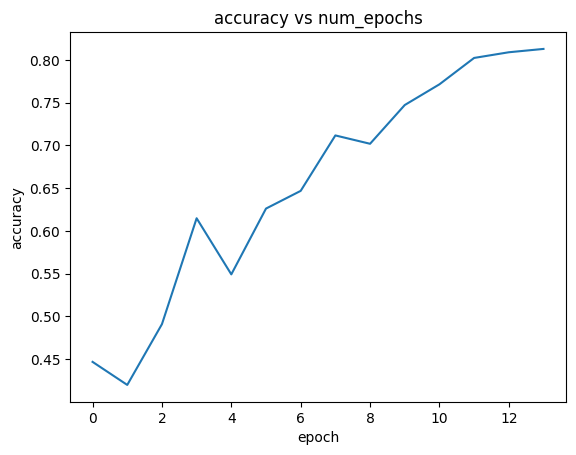

In [ ]:
def plot_Accuracies(history):
    plt.plot([x["val_acc"] for x in history])
    plt.xlabel("epoch")
    plt.ylabel("accuracy")
    plt.title("accuracy vs num_epochs")


plot_Accuracies(history)

In [ ]:
def plot_losses(history):
    train_losses=[x["train_loss"] for x in history]
    val_losses=[x["val_loss"] for x in history]
    plt.plot(train_losses,"-bx")
    plt.plot(val_losses,"-rx")
    plt.xlabel("epoch")
    plt.ylabel("loss")
    plt.legend(["Training","Validation"])
    plt.title("loss vs No of epochs")

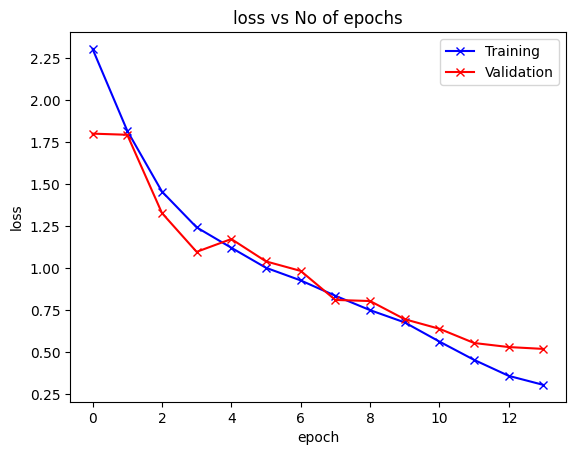

In [ ]:
plot_losses(history)

In [ ]:
def plot_lrs(history):
    lrs=np.concatenate([x.get("lrs",[]) for x in history])
    plt.plot(lrs)
    plt.xlabel("Batch_no")
    plt.ylabel("learning rate")
    plt.title("Learning rate vs batch no")

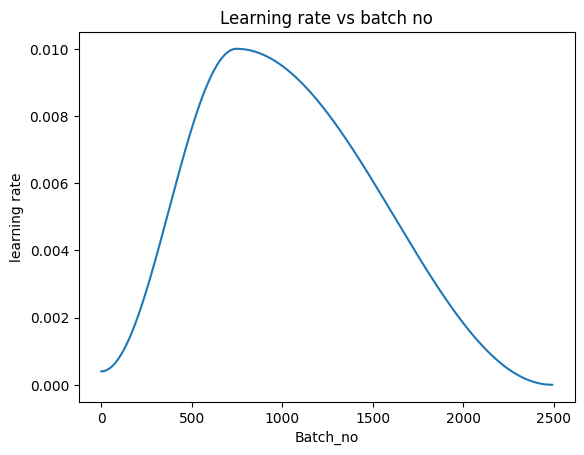

In [ ]:
plot_lrs(history)

#### Second Iteration

In [ ]:
lr=0.0003
epochs2=5

In [ ]:
history2=fit(epochs2,lr,model,train_dl,val_dl,grad_clip=grad_clip,weight_decay=weight_decay,opt_fn=opt_func)

Epoch [0], train_loss:0.3495 val_loss: 0.5302, val_acc: 0.8145
Epoch [1], train_loss:0.3206 val_loss: 0.5078, val_acc: 0.8199
Epoch [2], train_loss:0.3009 val_loss: 0.5234, val_acc: 0.8168
Epoch [3], train_loss:0.2888 val_loss: 0.5313, val_acc: 0.8234
Epoch [4], train_loss:0.2673 val_loss: 0.5508, val_acc: 0.8273


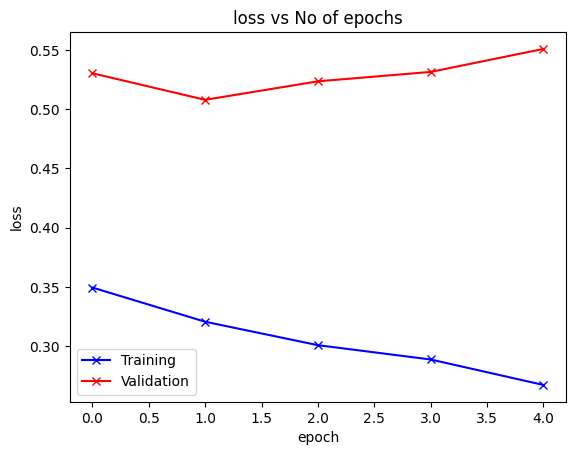

In [ ]:
plot_losses(history2)

## Evaluation

In [ ]:
test_dl=Device_Data_Loader(test_dl,device)
evaluate(model,test_dl)

{'val_loss': 0.5440433025360107, 'val_acc': 0.8213140964508057}

In [ ]:
torch.save(model.state_dict(),"final.pth")